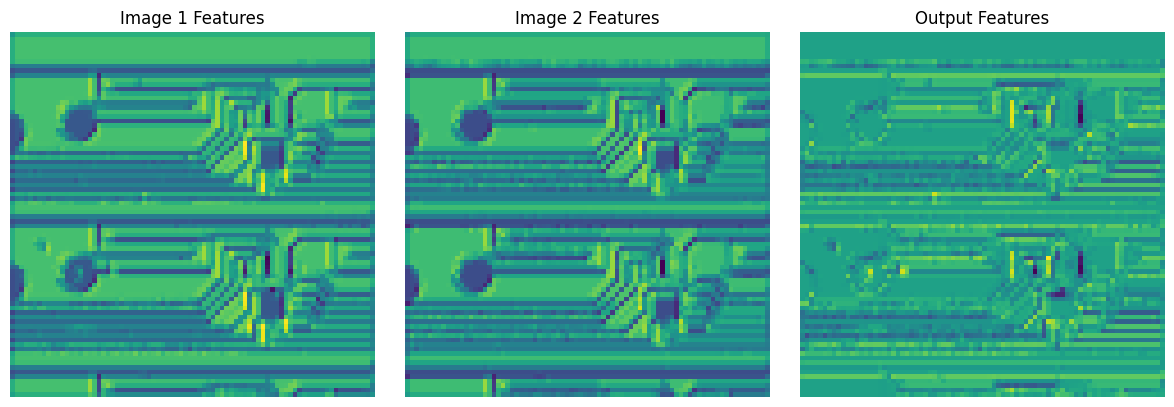

In [11]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

class BaseConvBlock(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(BaseConvBlock, self).__init__()
        self.conv = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv(x)
        return x

class ConvolutionalBackbone(nn.Module):
    def __init__(self, input_channels=3):
        super(ConvolutionalBackbone, self).__init__()
        self.base_conv_block = BaseConvBlock(input_channels, output_channels=3)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.base_conv_block(x)
        x = self.maxpool(x)
        x = self.base_conv_block(x)
        x = self.maxpool(x)
        x = self.base_conv_block(x)
        x = self.maxpool(x)
        return x

# Function to subtract features of two images and apply Tanh activation
class FeatureSubtractionTanh(nn.Module):
    def __init__(self):
        super(FeatureSubtractionTanh, self).__init__()
        self.activation = nn.Tanh()

    def forward(self, image1_features, image2_features):
        subtracted_features = image1_features - image2_features
        output = self.activation(subtracted_features)
        return output

# Load your own images
image1_path = "image.jpg"
image2_path = "template.jpg"

# Load images using PIL and convert to tensors
transform = transforms.Compose([transforms.Resize((640, 640)), transforms.ToTensor()])
image1 = transform(Image.open(image1_path).convert("RGB")).unsqueeze(0)
image2 = transform(Image.open(image2_path).convert("RGB")).unsqueeze(0)

# Instantiate the backbone and feature subtraction module
backbone = ConvolutionalBackbone(input_channels=3)
feature_subtraction = FeatureSubtractionTanh()

# Extract features using the backbone
image1_features = backbone(image1)
image2_features = backbone(image2)

# Perform feature subtraction and apply Tanh activation
output_features = feature_subtraction(image1_features, image2_features)

# Visualize the feature maps
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Visualize features from image 1
axs[0].imshow(image1_features.squeeze().detach().numpy()[0], cmap='viridis')
axs[0].set_title('Image 1 Features')
axs[0].axis('off')

# Visualize features from image 2
axs[1].imshow(image2_features.squeeze().detach().numpy()[0], cmap='viridis')
axs[1].set_title('Image 2 Features')
axs[1].axis('off')

# Visualize output features after feature subtraction and Tanh activation
axs[2].imshow(output_features.squeeze().detach().numpy()[0], cmap='viridis')
axs[2].set_title('Output Features')
axs[2].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np

def compare_images(img1, img2):
    diff_img = np.zeros_like(img1)

    # Define the kernel size
    kernel_size = 10
    stride = 5

    # Iterate through the images
    for i in range(0, img1.shape[0] - kernel_size + 1, stride):
        for j in range(0, img1.shape[1] - kernel_size + 1, stride):
            # Extract the kernel from both images
            kernel1 = img1[i:i+kernel_size, j:j+kernel_size]
            kernel2 = img2[i:i+kernel_size, j:j+kernel_size]

            # Compute the absolute difference between the kernels
            diff = np.abs(kernel1 - kernel2)

            # If more than 17 pixels differ, mark them in red
            if np.sum(diff) > 50:
                # Get the indices where the difference is greater than zero
                diff_indices = np.where(diff > 0)
                # Assign red color to differing pixels
                for idx in range(len(diff_indices[0])):
                    x_idx = diff_indices[0][idx]
                    y_idx = diff_indices[1][idx]
                    diff_img[i+x_idx, j+y_idx] = [0, 0, 255]  # Red color

    return diff_img

# Load the two images
image1 = cv2.imread('image.jpg')
image2 = cv2.imread('template.jpg')

# Call the function to compare the images
result = compare_images(image1, image2)

# Display the result
cv2.imshow('Result', result)
cv2.waitKey(0)
cv2.destroyAllWindows()
